# 1) Simulation de données
### Simulation des observations de variables fonctionnelles

/home/diallo/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


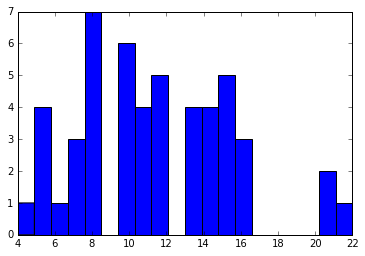

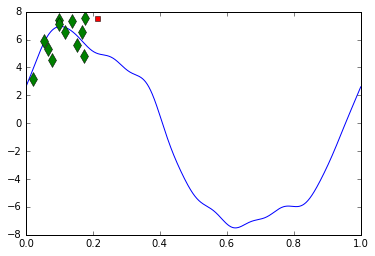

In [1]:
from Classes import * 
from Simu import *
from NLL import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import integrate
import sympy as sy
from scipy import linalg
import pylab as pl
import math as ma
import time 
%matplotlib inline
b=Base(np.array([1,4])).val(np.array([1,2]))

N=10
D=5
n_t_moy=25
varu1=5
varu2=2


# Simulation des temps 
(T,L,M_nt)=temps(N,D,n_t_moy)
(U,V1,V2)=X_Params(varu1,varu2,N,D)
vec=np.reshape(M_nt,(N*D,1))

fig1 = plt.figure().add_subplot(111)
fig1.hist(vec,bins=20)


# Exemple de signe vital simulé
t=np.linspace(0,1,1000)
X=X_fonc(t,U[0,0],V1[0,0,:],V2[0,0,:])

fig2 = plt.figure().add_subplot(111)
fig2.plot(t,X.val())

#plt.savefig("Ftraj.png")
Xdata=X_obs(U,V1,V2,L)
fig2.plot(L[0][0],Xdata[0][0],marker="d",markersize=10,linestyle="none")
fig2.plot(T[0],Xdata[0][0][len(Xdata[0][0])-1],marker="s",markersize=5,color="r")
#plt.savefig("Xobs.png")

### Simulation des labels $Y$, $C$ et $Y^C$

Moyenne et écart type des labels non censurés Y
-0.847255373557
5.07059511476
Pourcentage de données non censurées
80.0


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  1.,  2.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-11.5543143 , -10.55376277,  -9.55321125,  -8.55265972,
         -7.5521082 ,  -6.55155667,  -5.55100515,  -4.55045362,
         -3.5499021 ,  -2.54935057,  -1.54879904,  -0.54824752,
          0.45230401,   1.45285553,   2.45340706,   3.45395858,
          4.45451011,   5.45506163,   6.45561316,   7.45616468,   8.45671621]),
 <a list of 20 Patch objects>)

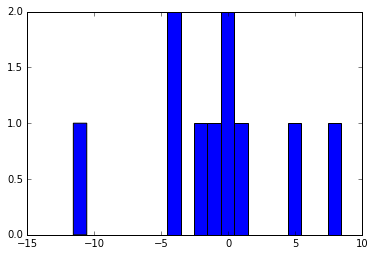

In [2]:
%matplotlib inline

Sigma=1
# Calcul de Beta aux sur la grille de t pour un jeu de coefficient donné
Kbeta=3
b=np.zeros((Kbeta*Kbeta,D),float)
b[0,:]=1.
# Nombre de variables scalaires
p=5
# Génération de Alpha et Z
Alpha=np.zeros(p,float)
Z=np.zeros((N,p),float)
(Y,C,Yc,Delta)=simu_YC(Alpha,Kbeta,b,Z,U,V1,V2,T,Sigma)
print "Moyenne et écart type des labels non censurés Y"
print np.mean(Y)
print np.std(Y)

print "Pourcentage de données non censurées"
print 100.*np.sum(Delta)/N

fig1 = plt.figure().add_subplot(111)
fig1.hist(Y,bins=20)


# 1) Régression GP sur Python pour l'inférence des variables GP

Nous allons commencer par l'utilisation la plus basique du package pyGPs qui est similaire à l'application que nous avons faîte des Gaussians Process sur R, à savoir la régression sur processus gaussien avec l'hypothèse d'un noyau exponentiel quadratique et d'une moyenne nulle. Cette utilisation nous est suffisante pour obtenir les estimateurs des paramètres de covariance (la variance et la portée de la fonction de covariance, ainsi que l'erreur résiduelle du modèle) que nous utiliserons dans un deuxième temps comme variables GP de la régression sur les logarithmes des temps de survie. 

## A) Un premier exemple tiré du package

On utilise le modèle de Régression sur Processus Gaussien :

$y_i = f(t_i) + \epsilon_i$ où les $\epsilon_i$ sont des erreurs gaussiennes $\mathcal{N}(0,sig)$ iid.

et $f\sim \mathcal{GP}(m,k)$.

Ce modèle de régression peut être utilisé dans le package pyGPs en utilisant la classe pyGPs.GPR(). Les options par défauts sont m=0, k=noyau exponentiel quadratique, une vraisemblance gaussienne (qui contient par défaut le bruit gaussien E_i) et une méthode d'optimisation par minimisation de la negative log vraisemblance relative aux hyperparamètres de m, k et sig.  

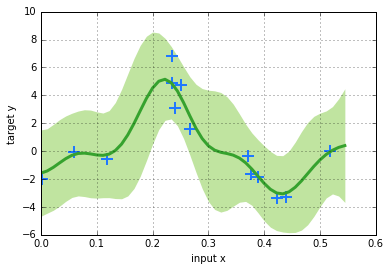

HYPERPARAMETRES AJUSTES
Moyenne empirique
0.568351667732
Moyenne estimée GP
3.60680386521
Hyperparamètres de la fonction de covariance estimés
[ 1.1165782   3.36547868  0.14544674  2.03725727  2.6947128 ]
Ecart type de l erreur gaussienne
1.12848882905


In [3]:
import pyGPs

# Données choisies pour l'exemple
idv=2
par=0

x=np.asarray(L[idv][par])
y=np.asarray(Xdata[idv][par])
z=np.linspace(0,T[idv],50)

moy=np.mean(y)

model = pyGPs.GPR()  # GP regression
# Spécification du modèle (Celles ci sont facultatives car elles correspondent aux paramètres par défaut de pyGPs.GPR)
# On définit la forme et les paramètres initiaux de la fonction de covariance du prior GP 
k1=pyGPs.cov.RBF(log_ell=0.0, log_sigma=0.0) 
k2=pyGPs.cov.Periodic(log_ell=0., log_p=0., log_sigma=0.)
k=pyGPs.cov.SumOfKernel(k1,k2)
# Evaluation d'un scalaire par la fonction
# Evaluation d'un array
m=pyGPs.mean.Const() # Fonction moyenne du GP (Ici constante nulle)
model.setPrior(mean=m,kernel=k) 
model.setNoise(log_sigma=-2.30258)# On peut aussi donner une valeur initiale pour la variance de l'erreur (0.1 ici)

# Inférence 
model.getPosterior(x, y) # fit default model (mean zero & rbf kernel) with data
model.optimize(x, y)     # optimize hyperparamters (default optimizer: single run minimize of gaussian likelihood)
model.predict(z)         # predict test cases
model.plot()             # and plot result

# Extraction des hyperparamètres optimisés
print('HYPERPARAMETRES AJUSTES')
print('Moyenne empirique')
print moy
print('Moyenne estimée GP')
print model.meanfunc.hyp[0]
print('Hyperparamètres de la fonction de covariance estimés')
print np.exp(model.covfunc.hyp)
print('Ecart type de l erreur gaussienne')
print np.exp(model.likfunc.hyp)[0]
# Voir la page détaillant les entrées des fonctions pour plus de détails sur les hyperparamètres avec d'autres modèles
# http://www-ai.cs.uni-dortmund.de/weblab/static/api_docs/pyGPs/Default.html


## B) Estimation des paramètres GP sur les données simulées 

In [4]:
model = pyGPs.GPR()
k1=pyGPs.cov.RBF(log_ell=0.0, log_sigma=0.0) 
k2=pyGPs.cov.Periodic(log_ell=0., log_p=0., log_sigma=0.)
k=pyGPs.cov.SumOfKernel(k1,k2)
m=pyGPs.mean.Const() 
model.setPrior(mean=m,kernel=k) 
model.setNoise(log_sigma=-2.30258)

par_est=np.zeros((N,D,len(model.covfunc.hyp)+1),float)
moy_est=np.zeros((N,D),float)

tps1 = time.clock()
for i in range(N):
    for j in range(D):
        # On effectue la régression sur processus gaussien pour chaque jeu de données et on stocke les paramètres estimés
        y=np.asarray(Xdata[i][j])
        x=np.asarray(L[i][j])
        model.optimize(x, y)
        moy_est[i,j]=model.meanfunc.hyp[0]
        par_est[i,j,:]=np.concatenate(  (np.array(np.exp(model.covfunc.hyp)), np.array(np.exp(model.likfunc.hyp))), axis=0 )
tps2 = time.clock()

nobs_moy=np.mean(M_nt)
print "temps écoulé pour ajuster ", N*D ," courbes avec en moyenne " , nobs_moy, " points :"
print(tps2 - tps1)

temps écoulé pour ajuster  50  courbes avec en moyenne  11.32  points :
2.552278


## C) Calcul de la vraisemblance de Y conditionnellement à X et aux paramètres estimés

Suite à une simulation de différentes séries temporelles, nous avons ajusté des paramètres associées à chacune d'entre elle selon un modèle de Régression sur Processus Gaussien. A présent, nous simulons les labels $Y_i$ selon le modèle VDFR en utilisant la trajectoire réelle des variables fonctionnelles. Puis, nous tentons d'évaluer la vraisemblance des labels $Y_i$ conditionellement aux $X^i_j$ et aux paramètres $\gamma^i_j,\theta^i_j,\eta^i_j$ appris avec la modélisation des variables fonctionnelles par des processus gaussien.

In [5]:

# Calcul des matrices de covariances et inverses Psi pour chaque courbe grâce aux paramètres estimés
N=len(L)
D=len(L[0])
n_par=len(par_est[0,0,:])-1
Psi=[[ [] for j in range(D)] for i in range(N)]
k=[[ [] for j in range(D)] for i in range(N)]
for i in range(N):
    for j in range(D):
        m_ij=len(L[i][j])
        par=par_est[i,j,:]
        k[i][j]=Sum( RBF(el=par[1],sig=par[2]) , Periodic(el=par[3],per=par[4],sig=par[5]) )
        K=  cov(k[i][j] , L[i][j] )
        
        Psi[i][j]=linalg.inv(K+par[0]*np.eye(m_ij))



def L_YlX_noC(P,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est):
    
    # Récupération des variables et paramètres 
    N=len(L)
    D=len(L[0])
    p=Z.shape[1]
    # Note : Kbeta est le degré de la base polynomiale selon une direction,
    # la taille de la base de fonction est donc Kbeta**2
    Kbeta=int(np.sqrt(Phi_mat.shape[1]))
    J=int(-1+Phi_mat.shape[0]/N)
    Alpha=P[0:p]
    Sigma=P[p]
    b=P[(p+1):(D*Kbeta**2+p+1)].reshape((Kbeta**2,D))
    Beta=Phi_mat.dot(b)
    
    # Intégrale de Phi(s,Ti)*K^{ijT}_*(s) c'està dire une Matrice (Kbeta**2,m_ij)  
    I1=PhiK(L,T,k,Phi_mat,J)

    # Intégrale double de k(s,t)*beta(s,Ti)*beta(t,Ti)  
    I2=kbb(T,k,Beta,J).val()
    
    # Vecteur contenant les espérances de Yi | Xi notées Ei
    EY=np.zeros(N,float)
    # Vecteur contenant les variances de Yi | Xi notées Vi
    VY=np.zeros(N,float)
    # Matrices contenant les Int_[0,Ti] E(F_ij(s)|X_ij)Beta_j(s,Ti) ds
    EY_Int=np.zeros((N,D),float)
    # Matrices contenant les Int_[0,Ti]² Cov(F_ij(s),F_ij(t)|X_ij) Beta_j(s,Ti)Beta_j(t,Ti) dsdt
    VY_Int=np.zeros((N,D),float)
    # Matrice des dEi/dbj
    dEdb=np.zeros((N,D,Kbeta**2),float)
    # Matrice des dVi/dbj
    dVdb=np.zeros((N,D,Kbeta**2),float)
    
    
    Un=np.ones(J+1,float)
    Un[0]=0.5
    Un[J]=0.5

    for i in range(N):
        for j in range(D):        
            Xij=Xdata[i][j]
            # Moyenne de F_ij estimée en amont
            Etaij=moy_est[i,j]
            
            # Note : Psi[i][j] = Matrice de Précision de X_ij 
            PhiKPsi_ij=I1[i][j].dot(Psi[i][j])
            PhiKPsiX_ij=PhiKPsi_ij.dot(Xij-Etaij)
            
            # Calcul de l'intégrale de dEi/dbj 
            PhiE_Fij =Un.dot(Phi_mat[(i*(J+1)):((i+1)*(J+1)) ,:]) * Etaij /J  + PhiKPsiX_ij
            dEdb[i,j,:]=PhiE_Fij/T[i]

            # Calcul de dVi/dbj
            Beta_ij= Beta[(i*(J+1)):(i*(J+1)+J+1),j]
            grid=T[i]*1.*np.arange(J+1)/J
            vecarg=expandnp([grid,grid])
            k_ij=np.reshape( np.apply_along_axis(k[i][j].val,axis=1,arr=vecarg) , (J+1,J+1) )
            k_ij[0,:]=k_ij[0,:]*0.5
            k_ij[J,:]=k_ij[J,:]*0.5
            k_ij[:,0]=k_ij[:,0]*0.5
            k_ij[:,J]=k_ij[:,J]*0.5
            PhiKBeta_ij=  Beta_ij.dot(k_ij).dot(Phi_mat[(i*(J+1)):(i*(J+1)+J+1),:])*(T[i]**2/J)
            dVdb[i,j,:]=( PhiKBeta_ij  - PhiKPsi_ij.dot( b[:,j].dot(I1[i][j]) ) ) / T[i]**2
            
            # Calcul de la composante de Ei selon la jème VFT
            EY_Int[i,j]=  b[:,j].dot(PhiE_Fij)
            # Calcul de la composante de Vi selon la jème VFT
            VY_Int[i,j]=I2[i][j] - b[:,j].dot(PhiKPsi_ij).dot( b[:,j].dot(I1[i][j]) )

        # On calcule l'espérance de Y sachant X avec l'espérance de Y et le terme de conditionnement gaussien
        EY[i]= Z[i].dot(Alpha) + np.sum( EY_Int[i,:] )  / T[i]
        # On calcule la variance de Y sachant X avec le terme de variance issu des VFT X^i_j et de l'erreur résiduelle 
        VY[i]= np.sum(  VY_Int[i,:] ) / (T[i]**2) + Sigma**2 

    # Calcul de la vraisemblance 
    L_YlX_noC = np.sum( (Y-EY)**2/VY + np.log(VY) )
    
    # Calcul du Gradient    
    # Par rapport à Alpha
    dL_YlXda_noC= np.ones(N,float).dot( (-2.*(Y-EY)/VY).repeat(p,axis=0).reshape((N,p)) *Z)  
    # Par rapport à Sigma²
    dL_YlXdsig_noC= np.sum( (1 - (Y-EY)**2/VY)/VY  )
    # Par rapport à b_j pour tout j de 1 à D
    dL_YlXdb_noC=np.zeros((Kbeta**2,D))
    for j in range(D): 
        dL_YlXdb_noC[:,j]=np.ones(N,float).dot(-2* ((Y-EY)/VY).repeat(Kbeta**2,axis=0).reshape((N,Kbeta**2))  * dEdb[:,j,:] + ( 1 - (Y-EY)**2/VY ).repeat(Kbeta**2,axis=0).reshape((N,Kbeta**2)) * dVdb[:,j,:] )   
    dL_YlXdb_noC= (dL_YlXdb_noC.T).reshape(-1) 
    # On renvoie le critère ainsi que le gradient
    return (L_YlX_noC , np.concatenate((dL_YlXda_noC.reshape(-1),np.array([dL_YlXdsig_noC]),dL_YlXdb_noC)) ); 





In [7]:
Kbeta=2

# On construit la base de fonction en tant qu'expression symbolique sympy
s=sy.Symbol('s')
t=sy.Symbol('t')
syPhi=sy.ones(Kbeta**2,1)
k=0
for i in range(Kbeta):
    for j in range(Kbeta):
        syPhi[k]=(s**i)*(t**j) 
        k+=1
sy.pprint(syPhi)

(Is,Ic,It)=J22_Ints(syPhi,1.)
I_pen=Is+2*Ic+It

b=np.zeros((N,D),float)
b[0,:]=np.ones(D,float)

def L_YlX_pen_noC(P,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est,I_pen,Lambda):
    
    # Récupération des variables et paramètres 
    N=len(L)
    D=len(L[0])
    p=Z.shape[1]
    Kbeta=int(np.sqrt(Phi_mat.shape[1])) # Kbeta est le degré de la base polynomiale selon une direction, 
    #la taille de la base complète est Kbeta**2
    b=P[(p+1):(D*Kbeta**2+p+1)].reshape((Kbeta**2,D))
    
    (L_YlX_pen_noC,Grad)=L_YlX_noC(P,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)
    # On ajoute la pénalité à la vraisemblance
    Pen=np.trace( (b.T).dot(I_pen).dot(b) )
    L_YlX_pen_noC +=  Lambda* Pen
    
    
    Grad_b=Grad[(p+1):(D*Kbeta**2+p+1)].reshape((Kbeta**2,D))
    
    # Par rapport à b_j pour tout j de 1 à D
    
    for j in range(D): 
        dL_YlXdb[:,j]+= Lambda*2*(I_pen).dot(b[:,j])
    Grad[(p+1):(D*Kbeta**2+p+1)]=(dL_YlXdb.T).reshape(-1) 
    # On renvoie le critère ainsi que le gradient
    return (L_YlX_pen_noC , np.concatenate((dL_YlXda_noC.reshape(-1),np.array([dL_YlXdsig_noC]),dL_YlXdb_noC)) ); 



⎡ 1 ⎤
⎢   ⎥
⎢ t ⎥
⎢   ⎥
⎢ s ⎥
⎢   ⎥
⎣s⋅t⎦
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.66666667]
 [ 0.          0.          0.66666667  0.5       ]]
[[ 0.          0.          0.          0.5       ]
 [ 0.          0.          0.5         0.66666667]
 [ 0.          0.5         0.          0.33333333]
 [ 0.5         0.66666667  0.33333333  0.5       ]]
[[ 0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.33333333]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.33333333  0.          0.16666667]]


In [71]:
Kbeta=10
b=np.random.normal(0.,10.,D*Kbeta**2)

J=10
Phi= Base([Kbeta,Kbeta])
Phi_mat= Comp_Phi(Phi,T,J)
# Tentative
Po=np.concatenate( ( Alpha.reshape(-1), np.array([Sigma]), b) )
print "Vraisemblance de Y|X sans la censure"
print time.clock()
print L_YlX_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)[0]
print time.clock()



Vraisemblance de Y|X sans la censure
526.818959
5267.00629264
527.528208


In [72]:
P_bounds=[]
for i in range(p):
    P_bounds.append((-100.,100.))
P_bounds.append((0.,100.))
for i in range(D*Kbeta**2):
    P_bounds.append((-100.,100.))
print "Optimisation"
print time.clock()
RES=sc.optimize.minimize(L_YlX_noC, x0=Po, args=(Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est) , method='BFGS', jac=True, options={'gtol': 1e-8, 'disp': True})
print time.clock()
print RES

Optimisation
527.719014
         Current function value: 5267.006293
         Iterations: 0
         Function evaluations: 20
         Gradient evaluations: 8
547.215759
      fun: 5267.0062926420724
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -4.34871425e+01,
         4.60531835e+06,   1.38173666e+06,   5.63945743e+05,
         2.58230050e+05,   1.26805800e+05,   6.54437059e+04,
         3.50540375e+04,   1.93211577e+04,   1.08983829e+04,
         6.27238721e+03,   2.68410270e+06,   8.73529307e+05,
         3.65952480e+05,   1.70111748e+05,   8.44737854e+04,
         4.40075825e+04,   2.37756349e+04,   1.32177443e+04,
         7.52525503e+03,   4.37742736e+03,   1.66314653e+06,
         5.77323408e+05

In [43]:
x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
RES=sc.optimize.minimize( sc.optimize.rosen, x0=x0,method='BFGS', jac=sc.optimize.rosen_der, options={'gtol': 1e-6, 'disp': True})
print RES


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 52
         Function evaluations: 64
         Gradient evaluations: 64
      fun: 1.0115607171830986e-18
 hess_inv: array([[ 0.00742784,  0.01239067,  0.02361262,  0.04673885,  0.09348604],
       [ 0.01239067,  0.02483023,  0.04731168,  0.09365448,  0.18731921],
       [ 0.02361262,  0.04731168,  0.09490941,  0.18787576,  0.37577275],
       [ 0.04673885,  0.09365448,  0.18787576,  0.3768795 ,  0.75378359],
       [ 0.09348604,  0.18731921,  0.37577275,  0.75378359,  1.51262571]])
      jac: array([  4.35872671e-10,   3.31881744e-09,  -3.38990125e-08,
         3.45088873e-08,  -9.65729718e-09])
  message: 'Optimization terminated successfully.'
     nfev: 64
      nit: 52
     njev: 64
   status: 0
  success: True
        x: array([ 1.,  1.,  1.,  1.,  1.])


In [ ]:
Ph_mat_expr= 